# SVGD without kernels

In [1]:
%load_ext autoreload
from jax import config
config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
import json_tricks as json
import copy
from functools import partial

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import models

from jax.experimental import optimizers

key = random.PRNGKey(43)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


### Main

In [25]:
target = distributions.Banana([0,0], [4,1])
proposal = distributions.Gaussian([0,0], [9,9])
setup = distributions.Setup(target, proposal)

sizes = [32, 32, 2]
learning_rate = 1e-2
particle_lr = 1e-2
lambda_reg = 1
n_particles = 1000 # (num samples)
sample_every = False
noise_level = 0.0

rescale $\phi^*$ by
$$
\alpha = \frac{\text{SD}(\phi^*)}{2 \lambda \Vert \phi^* \Vert_{L^2(q)}^2}
$$

In [26]:
# def phistar(params, _, x, aux=False):
#     inducing_particles = params
#     phi = stein.get_phistar(kernel, target.logpdf, inducing_particles)
#     l2_phi_squared = utils.l2_norm(inducing_particles, phi)**2
#     ksd = stein.stein_discrepancy(inducing_particles, target.logpdf, phi)
#     alpha = ksd / (2*lambda_reg*l2_phi_squared)
#     if aux:
#         return -alpha*phi(x), {"ksd": ksd, "alpha": alpha}
#     else:
#         return -alpha*phi(x)


# def phistar_with_bandwidth_heuristic(params, _, x, aux=False):
#     inducing_particles = params
#     bandwidth = kernels.median_heuristic(inducing_particles)
#     kernel = kernels.get_rbf_kernel(bandwidth)

#     phi = stein.get_phistar(kernel, target.logpdf, inducing_particles)
#     l2_phi_squared = utils.l2_norm(inducing_particles, phi)**2
#     ksd = stein.stein_discrepancy(inducing_particles, target.logpdf, phi)
#     alpha = ksd / (2*lambda_reg*l2_phi_squared)
#     if aux:
#         return -alpha*phi(x), {"ksd": ksd, "alpha": alpha}
#     else:
#         return -alpha*phi(x)


def phistar_batched(params, _, particles, aux=False):
    kernel = kernels.get_rbf_kernel(1)
    inducing_particles = params
    phi = stein.get_phistar(kernel, target.logpdf, inducing_particles)
    l2_phi_squared = utils.l2_norm(inducing_particles, phi)**2
    ksd = stein.stein_discrepancy(inducing_particles, target.logpdf, phi)
    alpha = ksd / (2*lambda_reg*l2_phi_squared)
    if aux:
        return -alpha*vmap(phi)(particles), {"ksd": ksd, "alpha": alpha}
    else:
        return -alpha*vmap(phi)(particles)


def phistar_batched_adaptive(params, _, particles, aux=False):
    inducing_particles = params
    bandwidth = kernels.median_heuristic(inducing_particles)
    kernel = kernels.get_rbf_kernel(bandwidth)
    phi = stein.get_phistar(kernel, target.logpdf, inducing_particles)
    l2_phi_squared = utils.l2_norm(inducing_particles, phi)**2
    ksd = stein.stein_discrepancy(inducing_particles, target.logpdf, phi)
    alpha = ksd / (2*lambda_reg*l2_phi_squared)
    if aux:
        return -alpha*vmap(phi)(particles), {"ksd": ksd, "alpha": alpha}
    else:
        return -alpha*vmap(phi)(particles)

In [27]:
key, subkey = random.split(key)
stein_learner = models.SDLearner(subkey,
                                 target=target,
                                 sizes=sizes,
                                 learning_rate=learning_rate,
                                 lambda_reg=lambda_reg)

# ksd_learner = models.KernelLearner(subkey,
#                                   target,
#                                   sizes=[2],
#                                   activation_kernel=kernels.get_rbf_kernel(1),
#                                   learning_rate=learning_rate,
#                                   lambda_reg=lambda_reg,
#                                   scaling_parameter=True)


key, subkey = random.split(key)
particles_learned = models.Particles(subkey,
                                 gradient=stein_learner.kl_gradient,
                                 proposal=proposal,
                                 n_particles=n_particles,
                                 learning_rate=particle_lr,
                                 only_training=True)

particles_svgd = models.Particles(subkey,
                                 gradient=phistar_batched,
                                 proposal=proposal,
                                 n_particles=n_particles,
                                 learning_rate=particle_lr,
                                 only_training=True)

# particles_kernel_learned = models.Particles(subkey, # learn the KSD
#                                  gradient=ksd_learner.kl_gradient,
#                                  proposal=proposal,
#                                  n_particles=n_particles,
#                                  learning_rate=particle_lr,
#                                  only_training=True)

## Train SVGD and SVGD without kernels

In [28]:
n_steps=1000
train_steps=5
for _ in tqdm(range(n_steps)):
    train_x, val_x = particles_learned.get_params(split_by_group=True)
    x = stein_learner.train(train_x, val_x, key=subkey, n_steps=train_steps, noise_level=noise_level)
    particles_learned.step(stein_learner.get_params())

    inducing_particles, _ = particles_svgd.get_params(split_by_group=True)
    particles_svgd.step(inducing_particles)

#     train_x, _ = particles_kernel_learned.get_params(split_by_group=True)
#     ksd_learner.train(train_x, n_steps=train_steps)
#     particles_kernel_learned.step(ksd_learner.get_params())

100%|██████████| 1000/1000 [05:35<00:00,  2.98it/s]


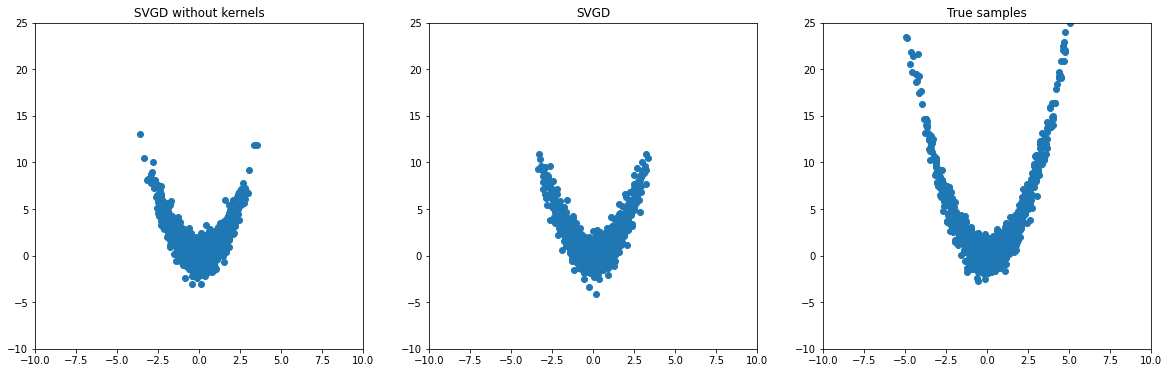

In [29]:
fig, axs = plt.subplots(1, 3, figsize=[20, 6])
axs = axs.flatten()
x_train_sl, single_val = particles_learned.get_params(split_by_group=True)
x_train_svgd, _ = particles_svgd.get_params(split_by_group=True)
# x_train_kernel_learned, _ = particles_kernel_learned.get_params(split_by_group=True)

x_true = target.sample(n_particles)
titles = ["SVGD without kernels", "SVGD", "True samples"]
samples = (x_train_sl, x_train_svgd, x_true)

xlims=(-10, 10)
ylims=(-10, 25)



for ax, x_train, title in zip(axs, samples, titles):
    plot.scatter(x_train, ax=ax)
#     plot.plot_fun_2d(target.pdf, type="contour", ax=ax, xlims=xlims, ylims=ylims)
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)
    ax.set_title(title)

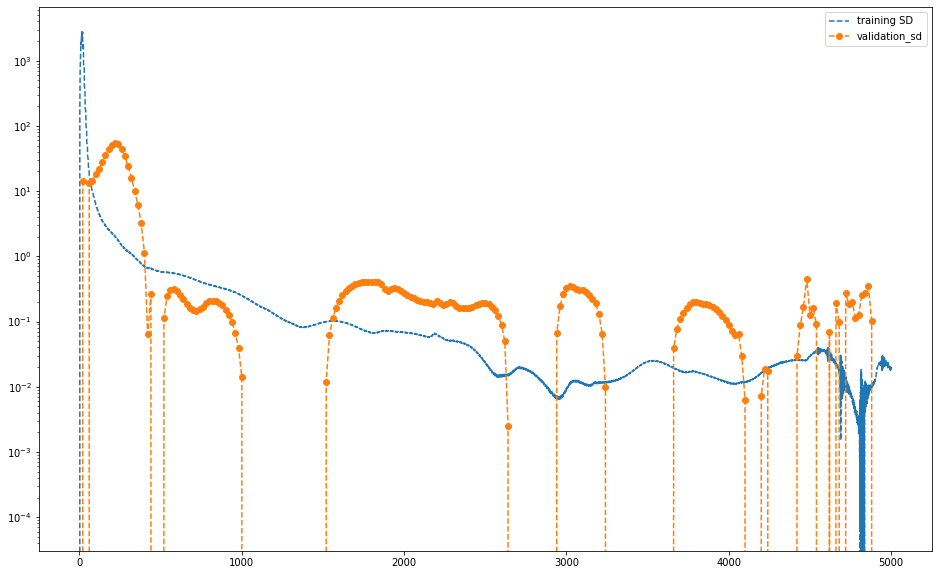

In [30]:
# %matplotlib widget
fig, ax = plt.subplots(figsize=[16, 10])

# scale_grid = np.arange(0, n_steps*10, step=10)
val_sd = np.array(stein_learner.rundata["validation_sd"])

ax.plot(stein_learner.rundata["training_sd"], "--", label="training SD")
# ax.plot(scale_grid, particles_svgd.rundata["ksd"], label="SVGD SD")
ax.plot(val_sd[:,0], val_sd[:,1], "--o", label="validation_sd")
# ax.set_ylim((-1,1))
ax.set_yscale("log")
ax.legend()

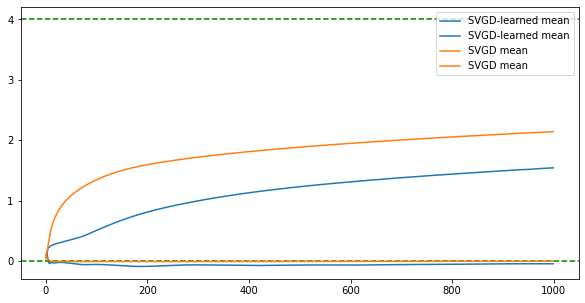

In [31]:
fig, ax = plt.subplots(figsize=[10,5])

ylim1=None
# ylim1 = (-10, 1.5)
# ylim1 = (-0.5, 1.5)
banana_mean = [0, 4]

ax.plot(particles_learned.rundata["training_mean"], label="SVGD-learned mean", color="tab:blue")
for mean in banana_mean if isinstance(target, distributions.Banana) else target.mean:
    ax.axhline(y=mean, linestyle="--", color="green")
ax.plot(particles_svgd.rundata["training_mean"], label="SVGD mean", color="tab:orange")
ax.set_ylim(ylim1)
ax.legend()